In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
#data = pd.read_csv('train.csv')

In [4]:
def disease_labels(line):
    dis = []
    for i in range(len(line)):
        if line[i] == '':
            dis.append(3) #Blank/Not Mentioned
            continue
        else:
            token = int(float(line[i]))
            
        if token == 1:
            dis.append(1) #Present
        elif token == 0:
            dis.append(0) #Absent
        elif token == -1:
            dis.append(2) #Uncertain
        else:
            print('Something Wrong')
            
    return dis
        
    

In [6]:
filename = []
patient_id = []
sex = []
age = []
extract = 'Frontal'
view = []
dis = []

i = 0

with open('CheXpert-v1.0-small/train.csv', 'r') as f:
    line = f.readline()
    print(line)
    
    i = i+1
    
    for line in f:
        line = line.replace('\n','')
        line = line.split(',')
        #print(line)

        filename.append(line[0])
        patient_id.append(int(line[0][33:38]))
        #print(patient_id)
        sex.append(line[1])
        age.append(line[2])
        if line[4] == "":
            view.append('LATERAL')
        else:
            view.append(line[4])
        dis.append(disease_labels(line[5:19]))

            #print(dis)
        
        #break

diseases = np.array(dis)

print(diseases.shape, len(view))
print('Total no of images: ', i)

Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices

(223414, 14) 223414
Total no of images:  1


In [ ]:
import torch
from torchvision import transforms

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


model = torch.hub.load('pytorch/vision:v0.5.0', 'densenet121', pretrained=True).to(device)
# or any of these variants
#model = torch.hub.load('pytorch/vision:v0.5.0', 'densenet169', pretrained=True).to(device)
#model = torch.hub.load('pytorch/vision:v0.5.0', 'densenet201', pretrained=True).to(device)
#model = torch.hub.load('pytorch/vision:v0.5.0', 'densenet161', pretrained=True).to(device)
model.eval()


def run_through_denseNetPyTorch(img, densenet_model, device):
    
    img = torch.unsqueeze(img.to(device), 0)
    
    with torch.no_grad():
        features = densenet_model.features( img )
        f_relu = torch.nn.functional.relu( features )
        pool = torch.nn.functional.adaptive_avg_pool2d( f_relu, (1,1) )

        y_st = pool.cpu().numpy().reshape(-1)
    
    return y_st

In [8]:
from imageio import imread 
import PIL 
from PIL import Image 
from torchvision import transforms 

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


images = []

X_train_0 = []

for i in range(len(filename)):
    if i%10000 == 0:
        print('Completed ', i, ' of ', len(filename))
    
    
    fname = filename[i]
    #print(fname)
    img = imread(fname, as_gray=False, pilmode="RGB") 
    
    img = Image.fromarray(img)
    img = PIL.ImageOps.equalize(img)
    img = preprocess(img)
    
    X_train_0.append(run_through_denseNetPyTorch(img=img, densenet_model=model, device=device))
    
    #images.append(img)

Completed  0  of  223414
Completed  10000  of  223414
Completed  20000  of  223414
Completed  30000  of  223414
Completed  40000  of  223414
Completed  50000  of  223414
Completed  60000  of  223414
Completed  70000  of  223414
Completed  80000  of  223414
Completed  90000  of  223414
Completed  100000  of  223414
Completed  110000  of  223414
Completed  120000  of  223414
Completed  130000  of  223414
Completed  140000  of  223414
Completed  150000  of  223414
Completed  160000  of  223414
Completed  170000  of  223414
Completed  180000  of  223414
Completed  190000  of  223414
Completed  200000  of  223414
Completed  210000  of  223414
Completed  220000  of  223414


In [9]:
data_dict = {}
data_dict['filename'] = filename
data_dict['patient_id'] = patient_id
data_dict['sex'] = sex
data_dict['age'] = age
data_dict['view'] = view

X_train_0 = np.array(X_train_0)

with open("Chexpert_Train_DenseNet121_Complete.npy", 'wb') as f:
    np.save(f,X_train_0)
    np.save(f,diseases)
    np.save(f,data_dict)

In [34]:
from sklearn.model_selection import train_test_split 

X_train = X_train_0
y_train = diseases[:,0]

print(X_train.shape)
print(y_train.shape)

(223414, 1024)
(223414,)


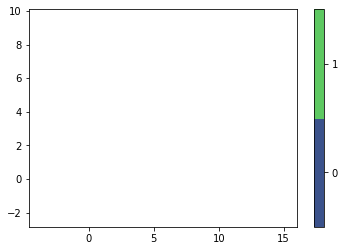

In [13]:
import umap 
 
    
import matplotlib.pyplot as plt
%matplotlib inline
    
np.random.seed(100) 
ump = umap.UMAP(n_neighbors=10, 
        min_dist=0.001, 
        n_components=2, 
        random_state=150, 
        n_epochs = 300,
        metric= 'euclidean') 
 
y_umap = ump.fit_transform(X_train) 
 
plt.figure() 
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral') 
 
cbar = plt.colorbar(boundaries=np.arange(3)-0.5) 
cbar.set_ticks(np.arange(3)) 
#cbar.set_ticklabels(classes) 

(223414, 2)


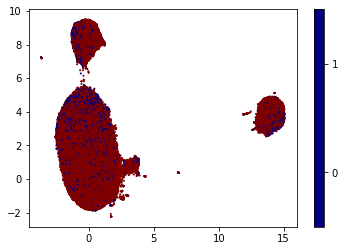

In [36]:
print(y_umap.shape)

plt.figure() 
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=1, cmap='jet') 
 
cbar = plt.colorbar(boundaries=np.arange(3)-0.5) 
cbar.set_ticks(np.arange(3)) 
#cbar.set_ticklabels(classes) 

(array([ 9588., 30125., 36190., 34288., 41198., 40716.,  4270.,   421.,
         9982., 16636.]),
 array([-2.2561798 , -1.0794889 ,  0.09720211,  1.2738931 ,  2.450584  ,
         3.627275  ,  4.803966  ,  5.980657  ,  7.1573477 ,  8.334039  ,
         9.51073   ], dtype=float32),
 <BarContainer object of 10 artists>)

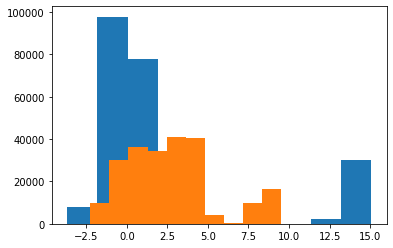

In [27]:
plt.figure()
plt.hist(y_umap[:,0])

plt.hist(y_umap[:,1])


In [32]:
print(y_train)

[]
